## Beni Shpringer - BS2UX - PySpark Assignment

### Setting up a Context

In [1]:
import pyspark
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)

### Preparation of Data

#### Load CSV file

In [2]:
dataPath = "2018_baseball_leaders.csv"
df = sqlc.read.format("csv")\
  .option("header","true")\
  .option("inferSchema", "true")\
  .load(dataPath)

#### Write df to parquet format

In [3]:
parquetPath = '/home/ec2-user/SageMaker/bs2ux/mlb_data3'
#df.write.parquet(parquetPath)

#### Read Parquet into a pyspark df

In [4]:
data = sqlc.read.parquet(parquetPath)
display(data)

DataFrame[Name: string, Team: string, G: int, PA: int, HR: int, R: int, RBI: int, SB: int, BB_pct: double, K_pct: double, ISO: double, BABIP: double, AVG: double, OBP: double, SLG: double, wOBA: double, wRC+: int, BsR: double, Off: double, Def: double, WAR: double, playerid: int]

#### Look at first row to get a sense of the data

In [5]:
data.take(1)

[Row(Name='Mookie Betts', Team='Red Sox', G=136, PA=614, HR=32, R=129, RBI=80, SB=30, BB_pct=0.132, K_pct=0.148, ISO=0.294, BABIP=0.368, AVG=0.346, OBP=0.438, SLG=0.64, wOBA=0.449, wRC+=185, BsR=6.9, Off=69.1, Def=11.6, WAR=10.4, playerid=13611)]

### MLlib based analysis 

In [6]:
# my contention is that higher BB% and lower K% will lead to a better babip.

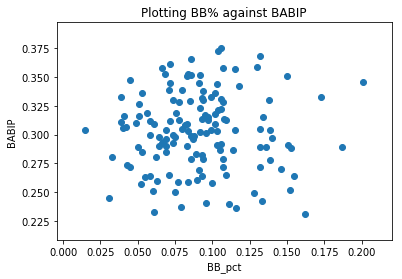

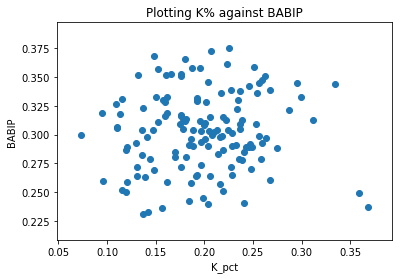

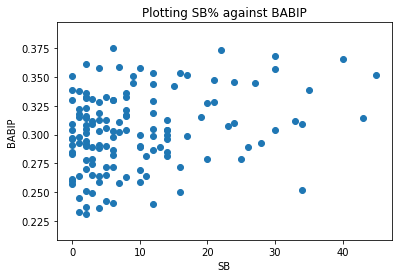

In [7]:
selected_data = data.select('BB_pct', 'K_pct', 'BABIP', 'SB')
pandas_df = selected_data.toPandas()
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

plt.scatter(pandas_df['BB_pct'], pandas_df['BABIP'])
plt.title('Plotting BB% against BABIP')
plt.xlabel('BB_pct')
plt.ylabel('BABIP')
plt.show()

plt.scatter(pandas_df['K_pct'], pandas_df['BABIP'])
plt.title('Plotting K% against BABIP')
plt.xlabel('K_pct')
plt.ylabel('BABIP')
plt.show()

plt.scatter(pandas_df['SB'], pandas_df['BABIP'])
plt.title('Plotting SB% against BABIP')
plt.xlabel('SB')
plt.ylabel('BABIP')
plt.show()

#### Well looks like there is no association between the three independent variables and BABIP, which is a little surprising 

In [8]:
seed = 99
(testDF, trainingDF) = selected_data.randomSplit((0.20, 0.80), seed=seed)
print ('training set N = {}, test set N = {}'.format(trainingDF.count(),testDF.count()))

training set N = 118, test set N = 22


In [9]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(
    inputCols=["BB_pct", "K_pct", "SB"],
    outputCol="features")

In [10]:
train_output = assembler.transform(trainingDF)
test_output = assembler.transform(testDF)

In [11]:
test_output.take(1)

[Row(BB_pct=0.049, K_pct=0.201, BABIP=0.31, SB=24, features=DenseVector([0.049, 0.201, 24.0]))]

In [12]:
trainingDF_renamed = train_output.withColumnRenamed("BABIP", "label").select('features','label')
testDF_renamed = test_output.withColumnRenamed("BABIP", "label").select('features','label')

In [13]:
trainingDF_renamed.take(1)

[Row(features=DenseVector([0.015, 0.136, 30.0]), label=0.304)]

In [14]:
# my contention is that players with lower stolen base totals will have a lower ISO 
# i want to compare linear regression to a random forest regression in terms of prediction accuracy

from pyspark.ml.regression import LinearRegression, LinearRegressionModel, RandomForestRegressor, RandomForestRegressionModel

linreg = LinearRegression()
ranfor = RandomForestRegressor()

linregmodel = linreg.fit(trainingDF_renamed)
ranformodel = ranfor.fit(trainingDF_renamed)

In [15]:
lr_preds = linregmodel.transform(trainingDF_renamed)#.select('features','label','prediction')
rf_preds = ranformodel.transform(testDF_renamed)#.select('features','label','prediction')

In [16]:
lr_preds.take(21)

[Row(features=DenseVector([0.015, 0.136, 30.0]), label=0.304, prediction=0.3218952393758776),
 Row(features=DenseVector([0.031, 0.199, 1.0]), label=0.245, prediction=0.3006773047561124),
 Row(features=DenseVector([0.033, 0.181, 14.0]), label=0.281, prediction=0.31061614293204054),
 Row(features=DenseVector([0.039, 0.15, 8.0]), label=0.333, prediction=0.30116404022118765),
 Row(features=DenseVector([0.039, 0.152, 7.0]), label=0.311, prediction=0.30045560504459845),
 Row(features=DenseVector([0.04, 0.11, 5.0]), label=0.306, prediction=0.29388912043594034),
 Row(features=DenseVector([0.041, 0.16, 2.0]), label=0.316, prediction=0.2965397691027979),
 Row(features=DenseVector([0.042, 0.11, 23.0]), label=0.307, prediction=0.31045808912435835),
 Row(features=DenseVector([0.043, 0.197, 3.0]), label=0.274, prediction=0.301396192070936),
 Row(features=DenseVector([0.045, 0.131, 6.0]), label=0.272, prediction=0.29675136009493713),
 Row(features=DenseVector([0.045, 0.259, 21.0]), label=0.347, predi

In [17]:
#import pyspark.sql.functions as func
#data.agg(func.avg(col("BABIP"))).take(1)[0]

In [18]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator()
print(eval.explainParams())

labelCol: label column name. (default: label)
metricName: metric name in evaluation - one of:
                       rmse - root mean squared error (default)
                       mse - mean squared error
                       r2 - r^2 metric
                       mae - mean absolute error. (default: rmse)
predictionCol: prediction column name. (default: prediction)


In [19]:
lr_rmse = eval.setMetricName("rmse").evaluate(lr_preds)
lr_rmse

0.0321953720384096

In [20]:
rf_rmse = eval.setMetricName("rmse").evaluate(rf_preds)
rf_rmse

0.03309570292224539

In [21]:
lr_r2 = eval.setMetricName("r2").evaluate(lr_preds)
lr_r2

0.07508788387993848

In [22]:
rf_r2 = eval.setMetricName("r2").evaluate(rf_preds)
rf_r2

0.008534550846022504

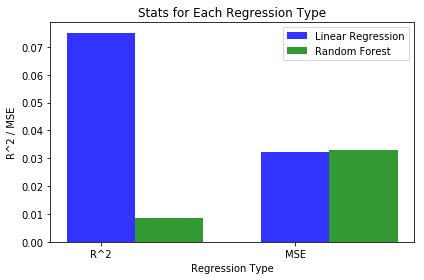

In [26]:
import numpy as np
n_groups = 2
stats_lr = (lr_r2, lr_rmse)
stats_rf = (rf_r2, rf_rmse)
fig, ax = plt.subplots()
index = np.arange(n_groups)
opacity = 0.8
bar_width = .35
rects1 = plt.bar(index, stats_lr, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Linear Regression')
 
rects2 = plt.bar(index + bar_width, stats_rf, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Random Forest')
plt.xlabel('Regression Type')
plt.ylabel('R^2 / MSE')
plt.title('Stats for Each Regression Type')
plt.xticks(index, ('R^2', 'MSE'))
plt.legend(loc = 1)
 
plt.tight_layout()
plt.show()